<a href="https://colab.research.google.com/github/rosanahjk/skills-introduction-to-github/blob/main/predicci%C3%B3n_turismo_CABA_SARIMA_2(otro%20par%C3%A1metros).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [143]:
import pandas as pd

import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, recall_score, precision_score, f1_score
import os
from sklearn.preprocessing import RobustScaler

from sklearn.impute import KNNImputer
from sklearn.preprocessing import OneHotEncoder

from sklearn.metrics import mean_squared_error, r2_score

from sklearn.tree import plot_tree
from sklearn import tree

from sklearn.metrics import mean_absolute_error


from sklearn.preprocessing import StandardScaler







# pára series temporales, esto permite descomponer

from statsmodels.tsa.seasonal import seasonal_decompose

# para agrupar los datos de fechas

from pandas.tseries.offsets import BMonthBegin

# para SARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

import warnings




# lineal regress

from scipy.stats import linregress

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# lectura de archivo


In [144]:
pd.set_option('display.max_columns', None)

# Ruta del archivo en Drive
file_path = '/content/drive/MyDrive/ENTUR/2.GOIM_Proyectos/Estimación turistas/Base estimación turismo internacional.xlsx'

# Cargar el archivo en un DataFrame
df = pd.read_excel(file_path)

# Mostrar los primeros datos del archivo
print(df.head())

    año  trim  mes    via                paso_publ       prov          limita  \
0  2016     1    1  Aéreo           Aero Bariloche  Río Negro  No corresponde   
1  2016     1    1  Aéreo           Aero Bariloche  Río Negro  No corresponde   
2  2016     1    1  Aéreo           Aero Bariloche  Río Negro  No corresponde   
3  2016     1    1  Aéreo           Aero Bariloche  Río Negro  No corresponde   
4  2016     1    1  Aéreo  Aero Comodoro Rivadavia     Chubut  No corresponde   

     pais_agrupado            pais  Total Arg bloque eti  \
0           Brasil          Brasil   7.000000        NaN   
1            Chile           Chile   6.000000        NaN   
2           Europa          Italia   1.125000        NaN   
3          Uruguay         Uruguay   1.052632        NaN   
4  EE.UU. y Canadá  Estados Unidos   8.938144        NaN   

                          clave  coef  Turistas CABA  
0           Aero Bariloche20161   0.0            0.0  
1           Aero Bariloche20161   0.0     

leer la base tc

In [145]:
pd.set_option('display.max_columns', None)

# Ruta del archivo en Drive
file_path1 = '/content/drive/MyDrive/Colab Notebooks/ETEUR/TCRM.xlsx'

# Cargar el archivo en un DataFrame
d_tc = pd.read_excel(file_path1)

# Mostrar los primeros datos del archivo
print(d_tc.head())

    Año  Mes        TCRM
0  2016    1   96.002130
1  2016    2  102.463407
2  2016    3  103.030241
3  2016    4   97.420265
4  2016    5   91.457390


In [146]:
#valores unicos de via
df["via"].unique()

array(['Aéreo', 'Fluvial/marítimo', 'Terrestre'], dtype=object)

In [147]:
#valores unicos de pais agrupado
df["pais_agrupado"].unique()

array(['Brasil', 'Chile', 'Europa', 'Uruguay', 'EE.UU. y Canadá',
       'Bolivia', 'Paraguay', 'Resto de América', 'Resto del mundo'],
      dtype=object)

In [148]:
df["via"] = df["via"].replace("AÃ©reo", "Aéreo")
df["via"] = df["via"].replace("Fluvial/marÃ\xadtimo", "Fluvial")
df["via"] = df["via"].replace("Terrestre", "Terrestre")
df["pais_agrupado"] = df["pais_agrupado"].replace("EE.UU. y CanadÃ¡", "EE.UU. y Canadá")
df["pais_agrupado"] = df["pais_agrupado"].replace("Resto de AmÃ©rica", "Resto de América")

# Renombrar las columnas correctamente si tienen errores de codificación
df.columns =[
    "año", "trim", "mes", "via", "paso_publ", "prov", "limita",
    "pais_agrupado", "pais", "total_turistas", "bloque_eti", "clave", "coef",
    "turistas_caba"
]

# Convertir valores numéricos con comas en decimales
df["total_turistas"] = df["total_turistas"].astype(str).str.replace(",", ".").astype(float)
df["turistas_caba"] = df["turistas_caba"].astype(str).str.replace(",", ".").astype(float)

df = df.dropna(subset=["turistas_caba"])    # elimina nulo de la columna turista_caba

# Ver las primeras filas para verificar que todo esté bien
print(df.head())

    año  trim  mes    via                paso_publ       prov          limita  \
0  2016     1    1  Aéreo           Aero Bariloche  Río Negro  No corresponde   
1  2016     1    1  Aéreo           Aero Bariloche  Río Negro  No corresponde   
2  2016     1    1  Aéreo           Aero Bariloche  Río Negro  No corresponde   
3  2016     1    1  Aéreo           Aero Bariloche  Río Negro  No corresponde   
4  2016     1    1  Aéreo  Aero Comodoro Rivadavia     Chubut  No corresponde   

     pais_agrupado            pais  total_turistas bloque_eti  \
0           Brasil          Brasil        7.000000        NaN   
1            Chile           Chile        6.000000        NaN   
2           Europa          Italia        1.125000        NaN   
3          Uruguay         Uruguay        1.052632        NaN   
4  EE.UU. y Canadá  Estados Unidos        8.938144        NaN   

                          clave  coef  turistas_caba  
0           Aero Bariloche20161   0.0            0.0  
1           

normalización

In [149]:
# Normalizar nombres de las categorías en 'pais_agrupado' y 'via'
df["pais_agrupado"] = df["pais_agrupado"].str.normalize("NFKD").str.encode("ascii", errors="ignore").str.decode("utf-8")
df["via"] = df["via"].str.normalize("NFKD").str.encode("ascii", errors="ignore").str.decode("utf-8")

agregar la columna indice de tiempo

In [150]:


# Supongamos que el DataFrame ya tiene las columnas "año", "trim" y "mes"
df["mes"] = df["mes"].astype(str).apply(lambda x: x.zfill(2))  # Asegurar formato "01", "02", etc.
df["trimestre"] = df["trim"].astype(str)  # Convertir trimestre a string
df["indice_tiempo"] = pd.to_datetime(df["año"].astype(str) + "/" + df["mes"] + "/01")  # Fijar día en '01'

# Mostrar el resultado
print(df[["año", "mes", "trim", "indice_tiempo"]].head())



    año mes  trim indice_tiempo
0  2016  01     1    2016-01-01
1  2016  01     1    2016-01-01
2  2016  01     1    2016-01-01
3  2016  01     1    2016-01-01
4  2016  01     1    2016-01-01


# exploración

In [151]:
# ver las dimenciones

dimencion= df.shape

# mirar las columnas
Colum= df.columns

print("dimencion: ", dimencion)
print("\n")
print("columnas: ", Colum)

dimencion:  (177089, 16)


columnas:  Index(['año', 'trim', 'mes', 'via', 'paso_publ', 'prov', 'limita',
       'pais_agrupado', 'pais', 'total_turistas', 'bloque_eti', 'clave',
       'coef', 'turistas_caba', 'trimestre', 'indice_tiempo'],
      dtype='object')


In [152]:
# ver si hay duplicados
df.duplicated().sum()

np.int64(0)

In [153]:
# ver info del df

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 177089 entries, 0 to 199593
Data columns (total 16 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   año             177089 non-null  int64         
 1   trim            177089 non-null  int64         
 2   mes             177089 non-null  object        
 3   via             177089 non-null  object        
 4   paso_publ       177089 non-null  object        
 5   prov            177089 non-null  object        
 6   limita          177089 non-null  object        
 7   pais_agrupado   177089 non-null  object        
 8   pais            177089 non-null  object        
 9   total_turistas  177089 non-null  float64       
 10  bloque_eti      42131 non-null   object        
 11  clave           177089 non-null  object        
 12  coef            177089 non-null  float64       
 13  turistas_caba   177089 non-null  float64       
 14  trimestre       177089 non-null  object  

Crear una nueva columna turista_caba1, Porque mis datos de turista_caba solo son los datos de turistas que ingresas a caba por via y por país, quiero poder visualizar los turistas totales que ingresan a caba por año y por mes, y que mi nueva columna tenga esos datos

In [154]:
# Asegurar que 'indice_tiempo' es tipo datetime y está como índice
df["indice_tiempo"] = pd.to_datetime(df["indice_tiempo"])
df.set_index("indice_tiempo", inplace=True)

# Agrupar por año y mes y sumar los turistas
df["turistas_caba1"] = df.groupby([df.index.year, df.index.month])["turistas_caba"].transform("sum")

# Mostrar las primeras filas para verificar
print(df.head())



                año  trim mes    via                paso_publ       prov  \
indice_tiempo                                                              
2016-01-01     2016     1  01  Aereo           Aero Bariloche  Río Negro   
2016-01-01     2016     1  01  Aereo           Aero Bariloche  Río Negro   
2016-01-01     2016     1  01  Aereo           Aero Bariloche  Río Negro   
2016-01-01     2016     1  01  Aereo           Aero Bariloche  Río Negro   
2016-01-01     2016     1  01  Aereo  Aero Comodoro Rivadavia     Chubut   

                       limita    pais_agrupado            pais  \
indice_tiempo                                                    
2016-01-01     No corresponde           Brasil          Brasil   
2016-01-01     No corresponde            Chile           Chile   
2016-01-01     No corresponde           Europa          Italia   
2016-01-01     No corresponde          Uruguay         Uruguay   
2016-01-01     No corresponde  EE.UU. y Canada  Estados Unidos   

    

In [155]:
# ver columna
df.head()

,año,trim,mes,via,paso_publ,prov,limita,pais_agrupado,pais,total_turistas,bloque_eti,clave,coef,turistas_caba,trimestre,turistas_caba1
indice_tiempo,,,,,,,,,,,,,,,,
2016-01-01,2016,1,01,Aereo,Aero Bariloche,Río Negro,No corresponde,Brasil,Brasil,7.000000,NaN,Aero Bariloche20161,0.0,0.0,1,248684.380537
2016-01-01,2016,1,01,Aereo,Aero Bariloche,Río Negro,No corresponde,Chile,Chile,6.000000,NaN,Aero Bariloche20161,0.0,0.0,1,248684.380537
2016-01-01,2016,1,01,Aereo,Aero Bariloche,Río Negro,No corresponde,Europa,Italia,1.125000,NaN,Aero Bariloche20161,0.0,0.0,1,248684.380537
2016-01-01,2016,1,01,Aereo,Aero Bariloche,Río Negro,No corresponde,Uruguay,Uruguay,1.052632,NaN,Aero Bariloche20161,0.0,0.0,1,248684.380537
2016-01-01,2016,1,01,Aereo,Aero Comodoro Rivadavia,Chubut,No corresponde,EE.UU. y Canada,Estados Unidos,8.938144,NaN,Aero Comodoro Rivadavia20161,0.0,0.0,1,248684.380537


# seleccionar variable de interes
La finalidad es ver total de visitante a parque nacionales.

               turistas_caba1
indice_tiempo                
2016-01-01      248684.380537
2016-01-01      248684.380537
2016-01-01      248684.380537
2016-01-01      248684.380537
2016-01-01      248684.380537


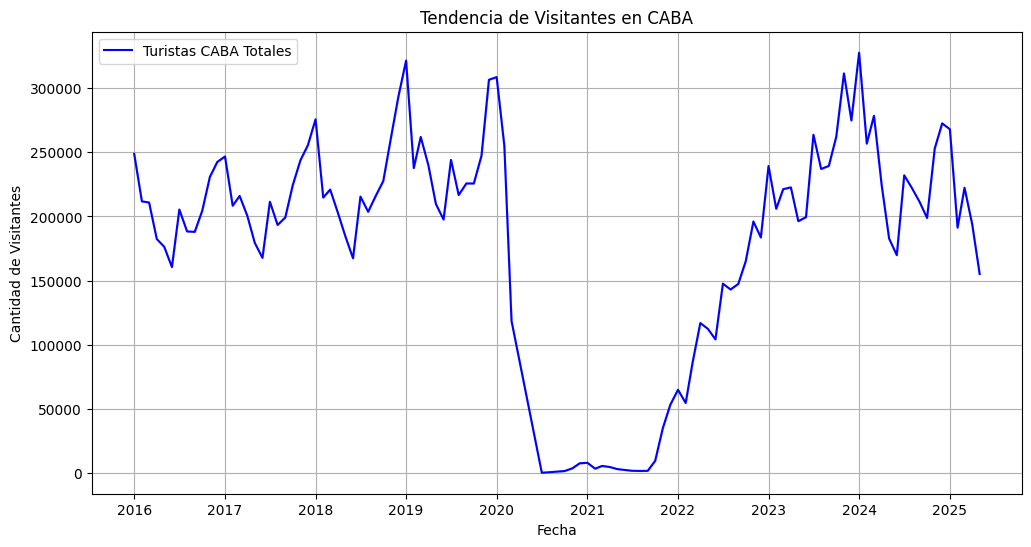

In [156]:
# Crear una copia con solo el índice de tiempo y turistas_caba1
dff = df[["turistas_caba1"]].copy()

# Mostrar las primeras filas para verificar
print(dff.head())

# El índice "indice_tiempo" ya está en el DataFrame, así que puedes visualizar tendencias directamente
plt.figure(figsize=(12, 6))
sns.lineplot(data=dff, x=dff.index, y="turistas_caba1", color="blue", label="Turistas CABA Totales")

plt.title("Tendencia de Visitantes en CABA")
plt.xlabel("Fecha")
plt.ylabel("Cantidad de Visitantes")
plt.grid(True)
plt.legend()
plt.show()



In [157]:
dff.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 177089 entries, 2016-01-01 to 2025-05-01
Data columns (total 1 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   turistas_caba1  177089 non-null  float64
dtypes: float64(1)
memory usage: 2.7 MB


In [158]:
#ver los valores faltantes
dff.isnull().sum()

,0
turistas_caba1,0


In [159]:
# usar la fecha en formato fecha, al parecer mi frecuencia es cada 5 meses
#dff['indice_tiempo'] = pd.to_datetime(dff['indice_tiempo'], format="%Y-%m-%d") # Se especifica el formato día/mes/año




# Si quieres resamplear datos de una frecuencia más alta:
# df_5meses = df.resample('5M').mean()  # Calcula la media por cada período de 5 meses

#  la fecha como índice del DataFrame para facilitar el acceso a las observaciones en función del tiempo
# SARIMA,  necesita que las observaciones estén indexadas por fecha para analizar tendencias y estacionalidades

#dff.set_index('indice_tiempo')




In [160]:
# eliminar espacios en blanco
# Aplicar str.strip() a todas las columnas de tipo string
dff = dff.apply(lambda x: x.str.strip() if x.dtype == "object" else x)

# Eliminar espacios en blanco en los nombres de las columnas
dff.columns = dff.columns.str.strip()

In [161]:
# ver los primeros tres datos

dff.head(3)

dff.columns

Index(['turistas_caba1'], dtype='object')

ver indice tiempo

In [162]:
print("indice duplicados",dff.index.duplicated().sum())  # Número de índices duplicados
print(dff[dff.index.duplicated(keep=False)])  # Muestra filas con índice duplicado
print(dff.index.names)  # Muestra el nombre del índice

# tiene duplicado

indice duplicados 176979
               turistas_caba1
indice_tiempo                
2016-01-01      248684.380537
2016-01-01      248684.380537
2016-01-01      248684.380537
2016-01-01      248684.380537
2016-01-01      248684.380537
...                       ...
2025-05-01      155178.999734
2025-05-01      155178.999734
2025-05-01      155178.999734
2025-05-01      155178.999734
2025-05-01      155178.999734

[177089 rows x 1 columns]
['indice_tiempo']


In [163]:
# Eliminar filas con índices duplicados, manteniendo solo la primera aparición
dff = dff[~dff.index.duplicated(keep="first")]

# Confirmar que ahora el índice es único
print(f"Índices duplicados después de la limpieza: {dff.index.duplicated().sum()}")


Índices duplicados después de la limpieza: 0


# control de valores extremos

In [164]:
# Filtrar los datos dentro del rango 0-1, para ver si hay valores que sean cero
filtro = (df["turistas_caba1"] >= 0) & (df["turistas_caba1"] <= 1)
datos_en_rango = df[filtro]

# Calcular el porcentaje
porcentaje = (len(datos_en_rango) / len(df)) * 100

print(f"Porcentaje de datos entre 0 y 1: {porcentaje:.2f}%")

Porcentaje de datos entre 0 y 1: 0.00%


ver los valores atípicos

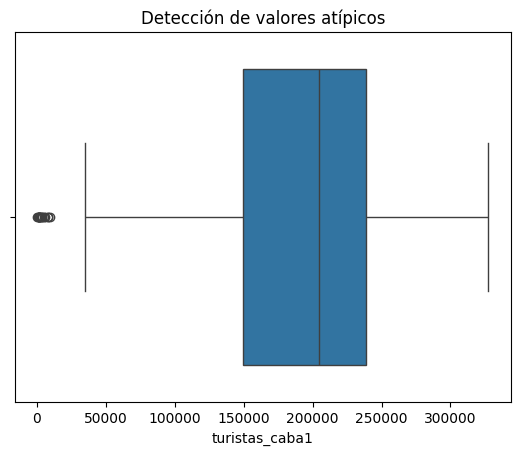

In [165]:
sns.boxplot(x=dff["turistas_caba1"])
plt.title("Detección de valores atípicos")
plt.show()

Del gráfico anterior se puede ver que los datos atípicos se concentran el cuartil inferior

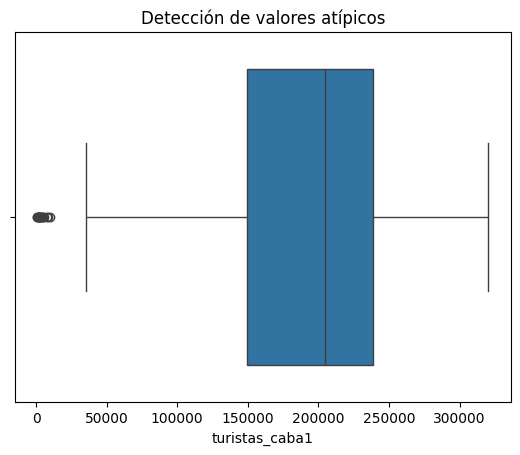

In [166]:
# Limitar los valores entre el percentil 6 y 99,  tiene muchos datos atípicos, y la información esta muy sesgada hacia la izquierda
limite_inferior = np.percentile(dff["turistas_caba1"], 1)
limite_superior = np.percentile(dff["turistas_caba1"], 99)

dff["turistas_caba1"] = np.clip(dff["turistas_caba1"], limite_inferior, limite_superior)

# ver la distribución despues de elimiar extremos
sns.boxplot(x=dff["turistas_caba1"])
plt.title("Detección de valores atípicos")
plt.show()

# visualizar

In [167]:
print(dff.columns)

# turista caba a tipo floar
dff["turistas_caba1"] = dff["turistas_caba1"].astype(float)
print(dff.dtypes)


Index(['turistas_caba1'], dtype='object')
turistas_caba1    float64
dtype: object


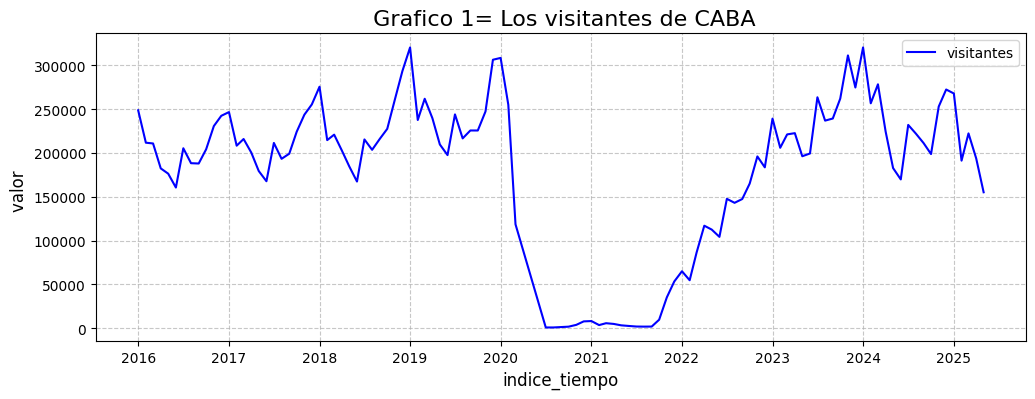

In [168]:
# Crear el gráfico
plt.figure(figsize=(12, 4))
sns.lineplot(data=dff, x=dff.index, y='turistas_caba1', color='blue', label='visitantes')




# Personalizaciones
plt.title(' Grafico 1= Los visitantes de CABA', fontsize=16)
plt.xlabel('indice_tiempo', fontsize=12)
plt.ylabel('valor ', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)




# Añadir la cuadrícula
plt.grid(True)

# Mostrar leyenda
plt.legend()



plt.show()

Se oberva en el gráfico  1 que hay periodos de  estacionalidades

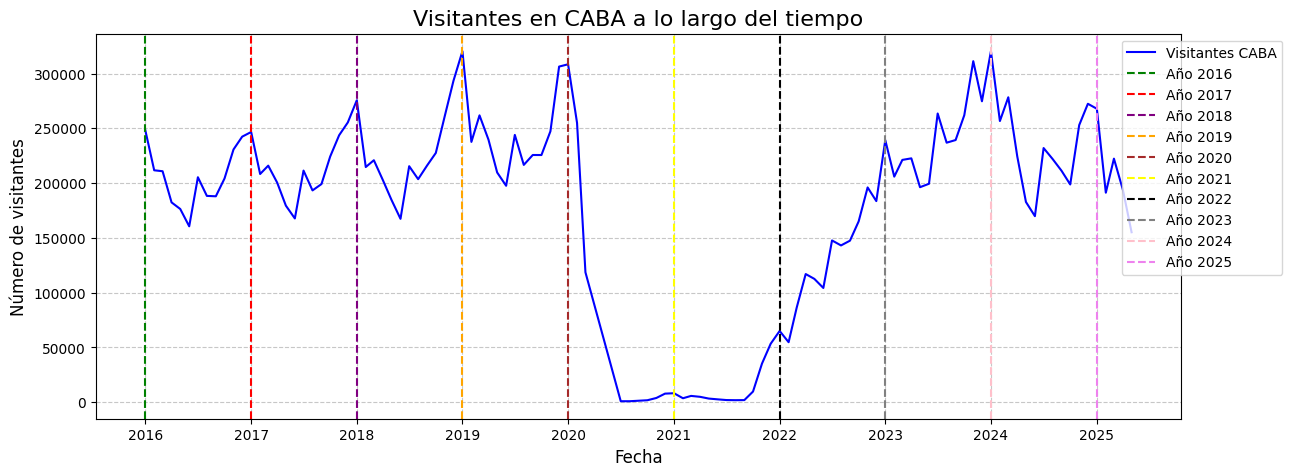

In [169]:


# Crear el gráfico usando el índice de tiempo
plt.figure(figsize=(14, 5))

sns.lineplot(data=dff, x=dff.index, y="turistas_caba1", color="blue", label="Visitantes CABA")

# Obtener los años únicos desde el índice
years = dff.index.year.unique()

# Paleta de colores para diferenciar cada año
colors = ['green', 'red', 'purple', 'orange', 'brown', 'yellow', 'black', 'grey', 'pink', 'violet']

# Agregar líneas verticales al inicio de cada año con diferentes colores
for i, year in enumerate(years):
    start_year = pd.to_datetime(f"{year}-01-01")
    plt.axvline(x=start_year, color=colors[i % len(colors)], linestyle='--', label=f'Año {year}')

# Personalizar el gráfico
plt.title('Visitantes en CABA a lo largo del tiempo', fontsize=16)
plt.xlabel('Fecha', fontsize=12)
plt.ylabel('Número de visitantes', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)

# Ajustar la posición de la leyenda
plt.legend(loc='upper right', bbox_to_anchor=(1.1, 1))

plt.show()


En el gráfico de arriba puede apreciarse temporadas altas de visitas en el verano y temporadas bajas en invierno, el año 2020-2021 fue un dato atípico dónde las visitas estaban planchada en cero por varios meses. Parce que en el año 2024 se empieza a recuperar la tendencia a valores similares a la pre pandemia

In [170]:

dff.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 110 entries, 2016-01-01 to 2025-05-01
Data columns (total 1 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   turistas_caba1  110 non-null    float64
dtypes: float64(1)
memory usage: 5.8 KB


ver si hay indice duplicado de indice

In [171]:
print("indice duplicados",dff.index.duplicated().sum())  # Número de índices duplicados
print(dff[dff.index.duplicated(keep=False)])  # Muestra filas con índice duplicado




indice duplicados 0
Empty DataFrame
Columns: [turistas_caba1]
Index: []


# calcula la autocorrelacion

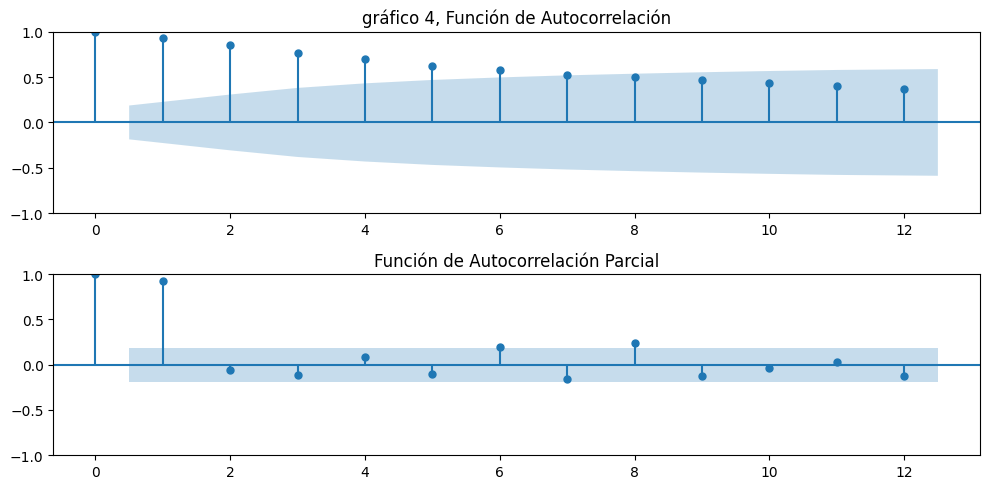

In [172]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
#calculando la autocorrelación y la autocorrelación parcial de losturistas en caba.
#Esto dirá si existe una relación directa entre los visitantes en diferentes puntos del tiempo.

# df['turistas_caba1'] sería la columna con los totales

# Visualizar la autocorrelación y autocorrelación parcial (PACF)
fig, axes = plt.subplots(2, 1, figsize=(10, 5))

# Autocorrelación (ACF)
plot_acf(dff['turistas_caba1'], lags=12, ax=axes[0])   # legs es el retardo
axes[0].set_title('gráfico 4, Función de Autocorrelación')

# Autocorrelación parcial (PACF)
plot_pacf(dff['turistas_caba1'], lags=12, ax=axes[1])
axes[1].set_title('Función de Autocorrelación Parcial')

plt.tight_layout()
plt.show()

Los lags mensuales estén por encima de la banda azul en la función de autocorrelación (ACF) sugiere que la serie de turistas en CABA presenta una  dependencia temporal. La serie no es estacionario presenta tendencia.
En la PACF, solo los primeros 1 o 2 meses tienen una correlación fuerte, lo que sugiere que la serie podría modelarse con un componente autorregresivo AR(2) en un modelo SARIMA.

#diferenciacion para eliminar la tendencia
Considición para trabajar con SARIMA

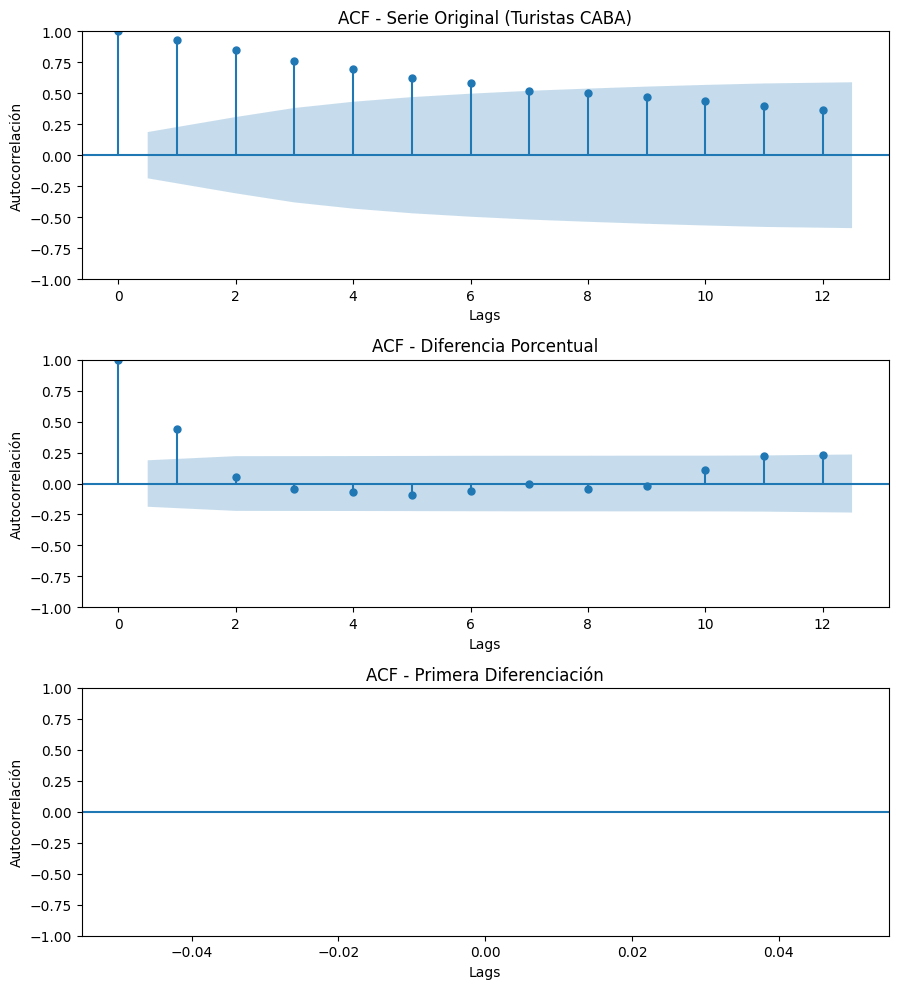

In [173]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller

# ✅ 1. Calcular la diferencia porcentual
porcDiff = dff["turistas_caba1"].pct_change().dropna()

# ✅ 2. Primera diferenciación para eliminar tendencia
dff["turistas_caba1_diff1"] = dff["turistas_caba1"].diff().dropna()

# 📊 4. Graficar ACF antes y después de la transformación
fig, axes = plt.subplots(3, 1, figsize=(9, 10))  # Aumentamos el alto del gráfico para evitar superposición

# ✅ Ajuste de espacio entre gráficos
plt.subplots_adjust(hspace=0.4)  # Espaciado entre subgráficos para mejor legibilidad

# Gráfico de ACF para la serie original
plot_acf(dff["turistas_caba1"], lags=12, alpha=0.05, ax=axes[0])
axes[0].set_title("ACF - Serie Original (Turistas CABA)")
axes[0].set_xlabel("Lags")
axes[0].set_ylabel("Autocorrelación")

# Gráfico de ACF para la diferencia porcentual
plot_acf(porcDiff, lags=12, alpha=0.05, ax=axes[1])
axes[1].set_title("ACF - Diferencia Porcentual")
axes[1].set_xlabel("Lags")
axes[1].set_ylabel("Autocorrelación")

# Gráfico de ACF para la primera diferenciación
plot_acf(dff["turistas_caba1_diff1"], lags=12, alpha=0.05, ax=axes[2])
axes[2].set_title("ACF - Primera Diferenciación")
axes[2].set_xlabel("Lags")
axes[2].set_ylabel("Autocorrelación")

# ✅ Aplicar ajuste automático para evitar superposición
plt.tight_layout()

# ✅ Mostrar los gráficos
plt.show()


con el gráfico de arriba se Concluye que  la diferenciación ha estabilizado la serie, eliminando la tendencia. Fue necesario solo una diferenciación

ver los valores nan en la nueva columa diferenciada

In [174]:
print("Valores NaN:", dff["turistas_caba1_diff1"].isna().sum())
print("Valores infinitos:", ((dff["turistas_caba1_diff1"] == float("inf")) | (dff["turistas_caba1_diff1"] == float("-inf"))).sum())


Valores NaN: 1
Valores infinitos: 0


Los lags significativos:

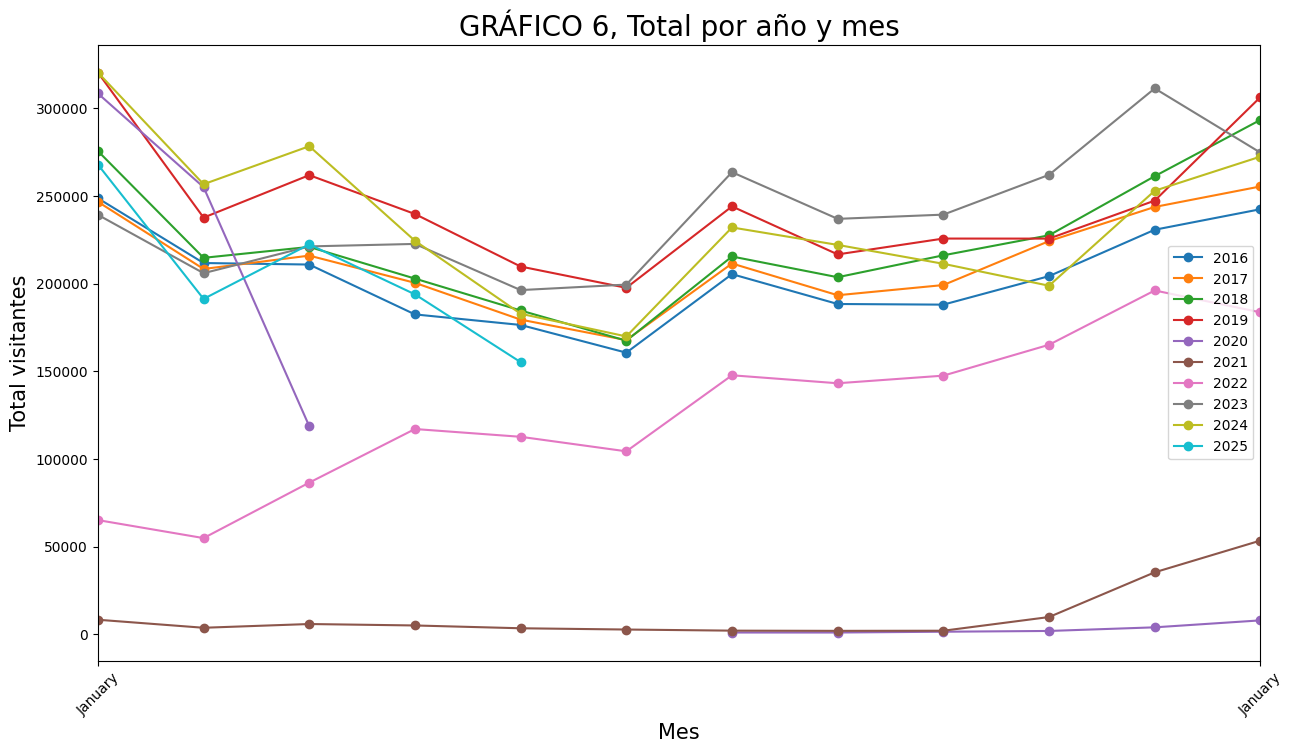

In [175]:
# Convertir el índice a formato de fecha si aún no lo está, asegurando que el formato es "Y/M/D"
# Cambiar el formato a '%Y-%m-%d' para que coincida con la fecha "2008-01-01"
#dff.index = pd.to_datetime(df['indice_tiempo'], format='%Y-%m-%d')

# Extraer atributos de fecha
dff["month"] = dff.index.month   #crea una nueva columna en el DataFrame llamada "month"
                                 #La propiedad .month extrae el número del mes de cada fecha en el índice
dff["year"] = dff.index.year  # IGUAL QUE ARRIBA CON EL AÑO

# Crear una tabla pivote
pivoted = dff.pivot_table(values='turistas_caba1', index='month', columns='year', aggfunc='mean')
pivoted.head()

#index='month', Especifica que queremos agrupar los datos por el mes. Los meses se convertirán en las filas de la nueva tabla

# Graficar

import matplotlib.dates as mdates

plt.figure(figsize=(15, 8))
for year in pivoted.columns:
    plt.plot(pivoted.index, pivoted[year], marker='o', label=year)

plt.title("GRÁFICO 6, Total por año y mes", fontsize=20)
plt.xlabel("Mes", fontsize=15)
plt.ylabel("Total visitantes", fontsize=15)

# Personalizar los ticks del eje x para mostrar los nombres completos de los meses
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%B'))

# Rotar las etiquetas del eje x para mejorar la legibilidad
plt.xticks(rotation=45)

# Ajustar los límites del eje x para que se vean todos los meses
plt.xlim(1, 12)  # De 1 a 12 para cubrir todos los meses del año

# Agregar leyenda
plt.legend()

plt.show()


In [176]:
# ver datos faltantes

print("datos faltantes",dff.isnull().sum())

# Ver tipos de datos de cada columna
print(dff.dtypes)

datos faltantes turistas_caba1          0
turistas_caba1_diff1    1
month                   0
year                    0
dtype: int64
turistas_caba1          float64
turistas_caba1_diff1    float64
month                     int32
year                      int32
dtype: object


crear variable dummies para datos atípicos, por los años de la pandemia

In [177]:
# 📌 4- Crear variables dummy para años atípicos,


# El efecto de los tres años es parecido por lo tanto se puede unificar en una columna


dff["is_anomalous_year"] = dff.index.year.isin([2020, 2021 ]).astype(int)

# datos atípico 2024
dff["is_2022"]= dff.index.year.isin([2022]).astype(int)


#Crear la variable `temporada_alta` usando el índice
#dff["temporada_alta"] = (dff.index.month == 7).astype(int)

#dff["impacto_temporada_alta"] = dff["temporada_alta"] * dff["turistas_caba1"].mean()






ver valores nan de exógenas

# agregar la variable tc

acoplar el archiv d_tc para poder acoplar a mi dff

In [178]:
d_tc.head()

,Año,Mes,TCRM
0,2016,1,96.002130
1,2016,2,102.463407
2,2016,3,103.030241
3,2016,4,97.420265
4,2016,5,91.457390


In [179]:
d_tc.columns

Index(['Año', 'Mes', 'TCRM'], dtype='object')

In [180]:
# Supongamos que el DataFrame ya tiene las columnas "año", "trim" y "mes"

# Supongamos que `d_tc` ya tiene las columnas "Año", "Mes" y "Trim"

# 📌 1- Asegurar que 'Mes' tenga formato correcto (dos dígitos)
d_tc["Mes"] = d_tc["Mes"].astype(str).apply(lambda x: x.zfill(2))  # Convertir "1" a "01", etc.

# 📌 2- Crear la columna `indice_tiempo` correctamente
d_tc["indice_tiempo"] = pd.to_datetime(d_tc["Año"].astype(str) + "/" + d_tc["Mes"].astype(str) + "/01")  # Día fijo en '01'

# 📌 3- Establecer `indice_tiempo` como índice
d_tc.set_index("indice_tiempo", inplace=True)

# 📌 4- Mostrar las primeras filas para verificar
print(d_tc.head())



                Año Mes        TCRM
indice_tiempo                      
2016-01-01     2016  01   96.002130
2016-02-01     2016  02  102.463407
2016-03-01     2016  03  103.030241
2016-04-01     2016  04   97.420265
2016-05-01     2016  05   91.457390


añadir la columna tc

In [181]:
dff = dff.merge(d_tc[["TCRM"]], left_index=True, right_index=True, how="left")


# SARIMA

In [182]:



#1- Definir los parámetros del modelo SARIMA basados en la PACF
# P COMPONENETE AUTORREGRESIVO, p=2 → Porque la PACF muestra una caída rápida en los primeros 2 lags.
#D DIFERENCIACION PARA SER ESTACIONAL, d=1 → La primera diferenciación hizo que la serie fuera estacionaria.
#q=2 → ACF muestra una reducción gradual en los primeros lags, indicando influencia de errores pasados.

# order = (6, 1, 6)  # p, d, q basados en los lags significativos

# P Y el Q son uno por la estacionalidad anual
# seasonal_order = (1, 1, 1, 12)  # P, D, Q, m para estacionalidad anual   # elemento estacional anual, s= 12 meses





In [183]:
print(df.index[:5])  # Ver cómo están formateadas las primeras fechas


DatetimeIndex(['2016-01-01', '2016-01-01', '2016-01-01', '2016-01-01',
               '2016-01-01'],
              dtype='datetime64[ns]', name='indice_tiempo', freq=None)


scalar

In [184]:
#from sklearn.preprocessing import StandardScaler



# scalar
scaler = StandardScaler()
dff["target_scaled"] = scaler.fit_transform(dff[["turistas_caba1"]])
#

# Modelar, SARIMAX

/tmp/ipython-input-197-634985474.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exog_train.fillna(exog_train.mean(), inplace=True)
/tmp/ipython-input-197-634985474.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exog_test.fillna(exog_test.mean(), inplace=True)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


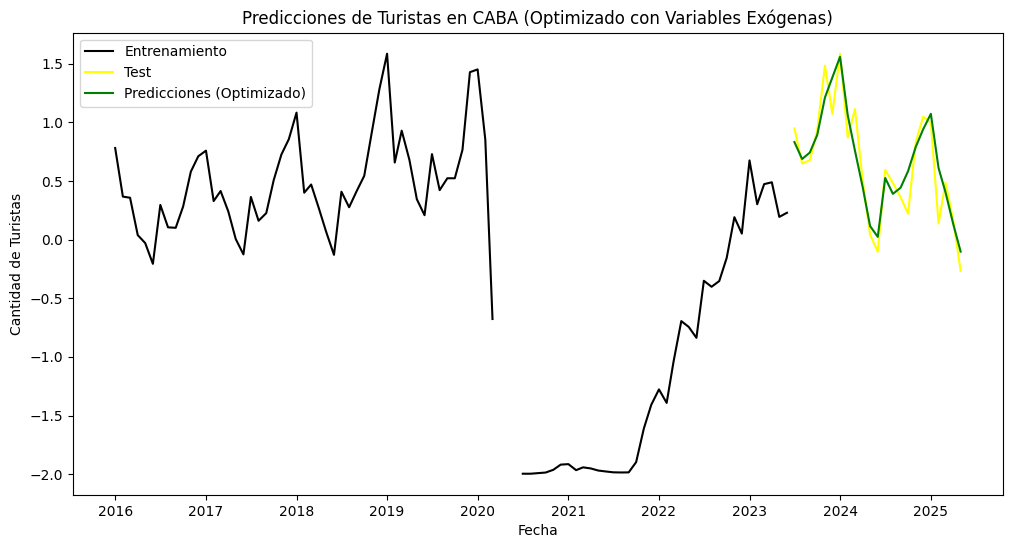

                                         SARIMAX Results                                          
Dep. Variable:                              target_scaled   No. Observations:                   90
Model:             SARIMAX(0, 1, 2)x(2, 1, [1, 2, 3], 12)   Log Likelihood                   1.605
Date:                                    Tue, 01 Jul 2025   AIC                             16.790
Time:                                            15:36:59   BIC                             33.166
Sample:                                        01-01-2016   HQIC                            22.617
                                             - 06-01-2023                                         
Covariance Type:                                      opg                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
is_anomalous_year    -0.1246      0.

In [197]:



dff = dff[~dff.index.duplicated(keep="first")]  # Mantener solo el primer registro


dff = dff.asfreq("MS")  # Ajustar frecuencia mensual (Inicio de mes)

# ordenar el indice antes de dividir

dff = dff.sort_index()


# 5- Definir la fecha de división y conjuntos de entrenamiento y prueba


split_idx = int(len(dff) * 0.8)  # 80% entrenamiento, 20% prueba
split_date = dff.index[split_idx] if split_idx < len(dff) else dff.index[-1]  # Ajuste para evitar IndexError


train = dff.loc[dff.index < split_date]
test = dff.loc[dff.index >= split_date]



# 6- Seleccionar las variables exógenas (ajustar si es necesario),
exog_vars =[ 'is_anomalous_year','is_2022']  # Agrega más si es necesario
exog_train = train[exog_vars]
exog_test = test[exog_vars]
target = 'target_scaled'  # Nombre de la columna de la variable dependiente

#  Reemplazar NaN con la media de cada columna
exog_train.fillna(exog_train.mean(), inplace=True)
exog_test.fillna(exog_test.mean(), inplace=True)

best_order = (0, 1, 2) # Por ejemplo: (2, 0, 1)
best_seasonal_order = (2, 1, 3, 12) # Por ejemplo: (1, 1, 1, 12)




# Usar los mejores hiperparámetros para ajustar el modelo final
final_model = SARIMAX(train['target_scaled'], order=best_order, seasonal_order=best_seasonal_order,
                        exog=exog_train, enforce_stationarity=False, enforce_invertibility=False)
final_result = final_model.fit(disp=False)
final_predictions = final_result.predict(start=len(train), end=len(train) + len(test) - 1,
                                           exog=exog_test)

plt.figure(figsize=(12, 6))
plt.plot(train['target_scaled'], label='Entrenamiento', color="black")
plt.plot(test['target_scaled'], label='Test', color="yellow")
plt.plot(test.index, final_predictions, label='Predicciones (Optimizado)', color='green')
plt.xlabel('Fecha')
plt.ylabel('Cantidad de Turistas')
plt.legend()
plt.title('Predicciones de Turistas en CABA (Optimizado con Variables Exógenas)')
plt.show()

print(final_result.summary())







rmse = np.sqrt(mean_squared_error(test['target_scaled'], final_predictions))
r2_scaled = r2_score(test['target_scaled'], final_predictions)

print(f"\nRMSE (escala escalada): {rmse}")
print(f"R-cuadrado (escala escalada): {r2_scaled}")

BUSQUEDA DE HIPER

##proyectar

In [193]:
# --- Parte 2: Búsqueda de la grilla y ajuste del modelo (sin cambios significativos aquí) ---
p_values = [0, 1, 2, 3]
d_values = [0, 1]
q_values = [0, 1, 2, 3]
P_values = [0, 1, 2, 3]
D_values = [0, 1]
Q_values = [0, 1, 2, 3]
s = 12  # Frecuencia estacional

best_rmse = float("inf")
best_order = None
best_seasonal_order = None

# Este proceso de búsqueda puede ser largo con TCR añadido, ya que es otra variable exógena
# que el modelo debe considerar.
print("\nIniciando la búsqueda de la grilla SARIMAX con TCR...")

for p in p_values:
    for d in d_values:
        for q in q_values:
            for P in P_values:
                for D in D_values:
                    for Q in Q_values:
                        order = (p, d, q)
                        seasonal_order = (P, D, Q, s)
                        try:
                            model = SARIMAX(train[target], order=order, seasonal_order=seasonal_order,
                                            exog=exog_train, enforce_stationarity=False, enforce_invertibility=False)
                            results = model.fit(disp=False)
                            predictions = results.predict(start=len(train), end=len(train) + len(test) - 1,
                                                          exog=exog_test)
                            rmse = np.sqrt(mean_squared_error(test[target], predictions))
                            if rmse < best_rmse:
                                best_rmse = rmse
                                best_order = order
                                best_seasonal_order = seasonal_order
                        except Exception as e:
                            print(f"Error al ajustar SARIMA con orden {order} y estacional {seasonal_order}: {e}")
                            continue  # Continuar incluso si hay errores para encontrar el mejor modelo que converja

print('Mejor RMSE:', best_rmse)
print('Mejor Order:', best_order)
print('Mejor Seasonal Order:', best_seasonal_order)



Iniciando la búsqueda de la grilla SARIMAX con TCR...


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for va

Mejor RMSE: 0.18721151955830342
Mejor Order: (0, 1, 2)
Mejor Seasonal Order: (2, 1, 3, 12)


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Modelo SARIMAX final ajustado. Resumen:
                                         SARIMAX Results                                          
Dep. Variable:                              target_scaled   No. Observations:                   90
Model:             SARIMAX(0, 1, 2)x(2, 1, [1, 2, 3], 12)   Log Likelihood                   1.605
Date:                                    Tue, 01 Jul 2025   AIC                             16.790
Time:                                            15:37:22   BIC                             33.166
Sample:                                        01-01-2016   HQIC                            22.617
                                             - 06-01-2023                                         
Covariance Type:                                      opg                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------

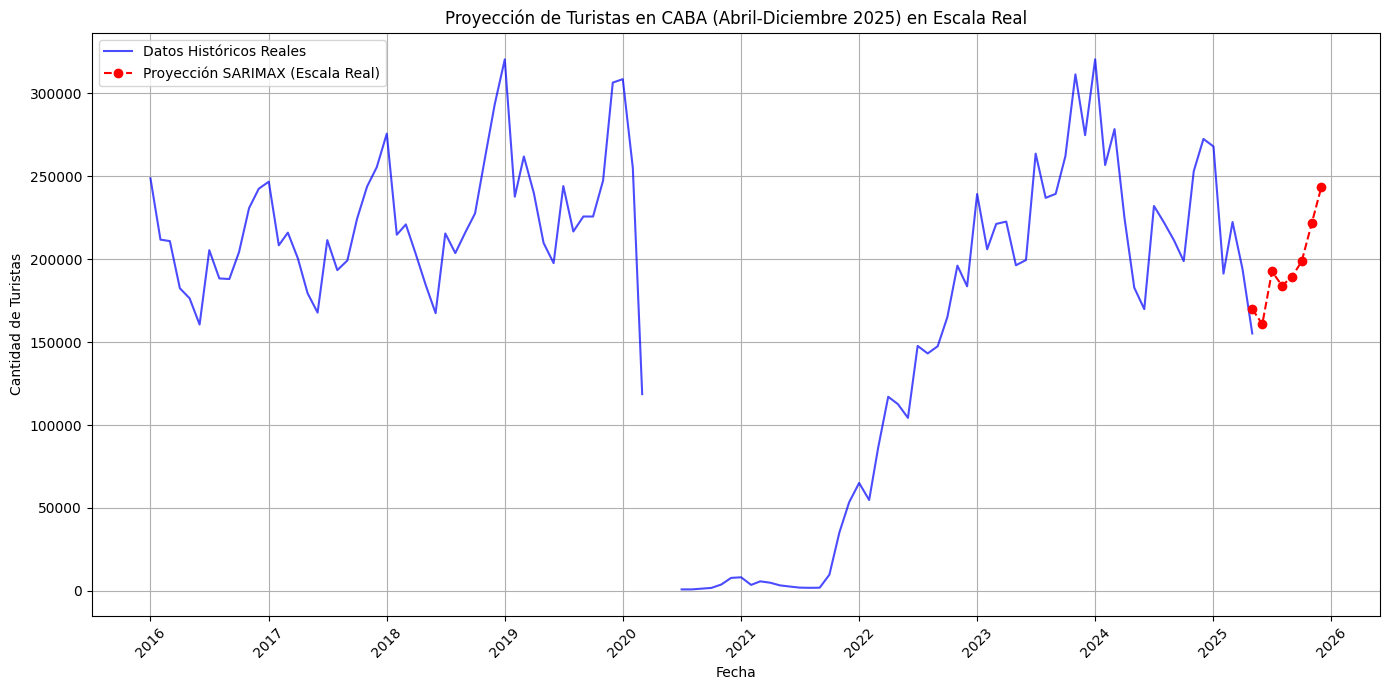

In [198]:


# Ajustar el escalador SOLO a los datos de entrenamiento originales (sin escalar)
# Si 'target_scaled' se obtuvo de 'turista_caba1', entonces debes ajustar sobre 'turista_caba1'
# Asegúrate de usar '.values.reshape(-1, 1)' al ajustar el scaler sobre una Serie de Pandas
scaler.fit(dff['turistas_caba1'].values.reshape(-1, 1))


# --- Parte 2: Usar los mejores hiperparámetros (obtenidos de tu grid search) y ajustar el modelo final ---
# Asegúrate de que 'best_order' y 'best_seasonal_order' estén definidos con los valores que encontraste

best_order = (0, 1, 2) # Por ejemplo: (2, 0, 1)
best_seasonal_order = (2, 1, 3, 12) # Por ejemplo: (1, 1, 1, 12)

 #Ajustar el modelo final con los mejores parámetros
final_model = SARIMAX(train[target], order=best_order, seasonal_order=best_seasonal_order,
                      exog=exog_train, enforce_stationarity=False, enforce_invertibility=False)
final_result = final_model.fit(disp=False)

print("Modelo SARIMAX final ajustado. Resumen:")
print(final_result.summary())

# --- Parte 3: Generar el período de proyección (Abril 2025 - Diciembre 2025) ---
last_date_in_dff = dff.index[-1]
start_forecast_date = pd.Timestamp('2025-05-01')
end_forecast_date = pd.Timestamp('2025-12-01')
future_index = pd.date_range(start=start_forecast_date, end=end_forecast_date, freq='MS')

# --- **MODIFIED: Parte 4: Crear las variables exógenas para el período de proyección *AND* the test set** ---
# Concatenate exog_test with the future exogenous data.
future_exog_data = pd.DataFrame(index=future_index)
future_exog_data['is_anomalous_year'] = 0
future_exog_data['is_2022'] = 0
future_exog_data = future_exog_data[exog_vars]  # Ensure column order

# Create a combined index for the test set and the future period
combined_index = test.index.union(future_index)

# Create a DataFrame for the combined exogenous data
combined_exog_data = pd.DataFrame(index=combined_index)

# Fill in the exogenous data for the test period
combined_exog_data[exog_vars] = exog_test.reindex(combined_index, fill_value=0) #Reindex and fill with 0 for missing values

# Fill in the exogenous data for the future period
combined_exog_data.loc[future_index, exog_vars] = future_exog_data[exog_vars]

# --- Parte 5: Realizar la proyección en escala escalada ---
forecast_scaled = final_result.predict(start=combined_index[0], end=combined_index[-1], exog=combined_exog_data)

# --- Parte 6: Desescalar las predicciones a la escala real ---
forecast_real_scale = scaler.inverse_transform(forecast_scaled.values.reshape(-1, 1))

# Convertir el array NumPy de vuelta a una Serie de Pandas con el índice de fecha correcto
forecast_real_scale = pd.Series(forecast_real_scale.flatten(), index=combined_index, name='turista_caba1_forecast')

print("\nProyección en escala real (Abril 2025 - Diciembre 2025):")
print(forecast_real_scale.loc[future_index]) # Print only the forecast period.


# --- Parte 7: Visualizar los resultados (opcional, pero recomendado) ---
plt.figure(figsize=(14, 7))
plt.plot(dff['turistas_caba1'], label='Datos Históricos Reales', color='blue', alpha=0.7)
plt.plot(forecast_real_scale.loc[future_index], label='Proyección SARIMAX (Escala Real)', color='red', linestyle='--', marker='o') # Plot only the forecast period
plt.xlabel('Fecha')
plt.ylabel('Cantidad de Turistas')
plt.title('Proyección de Turistas en CABA (Abril-Diciembre 2025) en Escala Real')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

guardar en un archivo

In [199]:
# Guardar en un archivo Excel
# Filtrar solo las proyecciones futuras
forecast_futuro = forecast_real_scale.loc[future_index]

# Guardar en un archivo Excel
forecast_futuro.to_excel("proyeccion_turistas_2025.xlsx", index=True)

print("Archivo Excel guardado exitosamente: proyeccion_turistas_2025.xlsx")


Archivo Excel guardado exitosamente: proyeccion_turistas_2025.xlsx


Proyecciones futuras

In [200]:
#Para ver dónde se guardó el archivo

!ls


drive  proyeccion_turistas_2025.xlsx  sample_data


# proyeccion con bandas


Proyección en escala real (Abril 2025 - Diciembre 2025) con Intervalos de Confianza del 95%:
               Pronóstico  Límite Inferior (95%)  Límite Superior (95%)
2025-06-01  160791.150790         -112717.032186          434299.333766
2025-07-01  192608.410237          -90172.182178          475389.002652
2025-08-01  183974.911489         -108550.630495          476500.453473
2025-09-01  189397.003596         -112717.846144          491511.853337
2025-10-01  198685.528838         -112723.482199          510094.539875
2025-11-01  221597.452398          -98836.256621          542031.161418
2025-12-01  243667.019802          -85544.085108          572878.124711
2026-01-01  264925.285078          -72835.194124          602685.764279
2026-02-01  222977.032734         -123127.997783          569082.063250
2026-03-01  227199.800737         -127054.103123          581453.704597
2026-04-01  222694.435578         -139404.685021          584793.556177
2026-05-01  213125.376145         -156649.

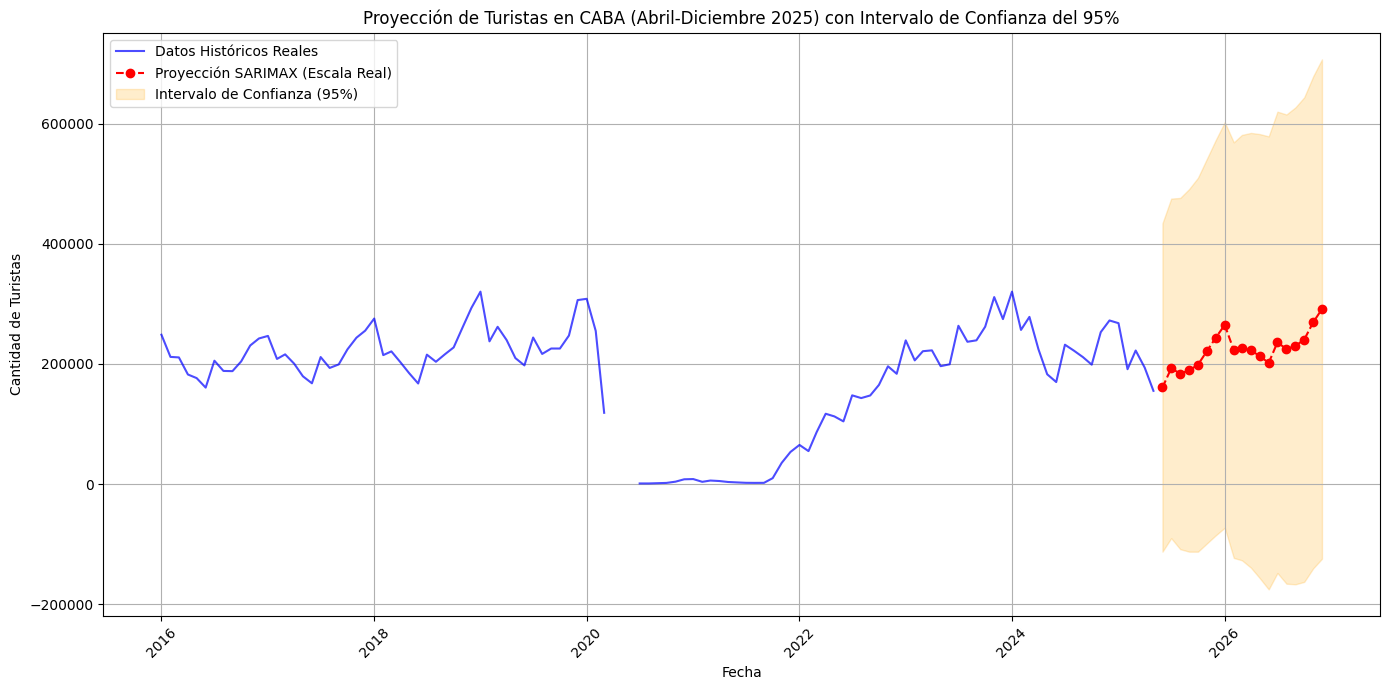

In [201]:
# --- Parte 3: Generar el período de proyección (Abril 2025 - Diciembre 2025) ---
last_date_in_dff = dff.index[-1]
start_forecast_date = pd.Timestamp('2025-06-01')
end_forecast_date = pd.Timestamp('2026-12-01')
future_index = pd.date_range(start=start_forecast_date, end=end_forecast_date, freq='MS')

# --- Parte 4: Crear las variables exógenas para el período de proyección *Y* el conjunto de prueba ---
combined_index = test.index.union(future_index)
combined_exog_data = pd.DataFrame(index=combined_index)
combined_exog_data['is_anomalous_year'] = 0
combined_exog_data['is_2022'] = 0
combined_exog_data = combined_exog_data[exog_vars]

# Llenar con los datos exógenos del conjunto de prueba
combined_exog_data.loc[test.index, exog_vars] = exog_test.reindex(test.index, fill_value=0)
# Llenar con los datos exógenos del período futuro
combined_exog_data.loc[future_index, exog_vars] = combined_exog_data.loc[future_index, exog_vars].fillna(0)


# --- Parte 5: Realizar la proyección en escala escalada CON INTERVALOS DE CONFIANZA ---
forecast_obj_scaled = final_result.get_forecast(steps=len(combined_index), exog=combined_exog_data)
forecast_summary_scaled = forecast_obj_scaled.summary_frame(alpha=0.10)

# AHORA USAMOS LOS NOMBRES CORRECTOS QUE ENCONTRAMOS:
col_lower = 'mean_ci_lower' # Actualizado
col_upper = 'mean_ci_upper' # Actualizado


# Obtenemos las predicciones y los intervalos de confianza del 90%
forecast_scaled = forecast_summary_scaled['mean'] # Predicciones en escala escalada
conf_int_lower_scaled = forecast_summary_scaled[col_lower] # Límite inferior escalado
conf_int_upper_scaled = forecast_summary_scaled[col_upper] # Límite superior escalado

# --- Parte 6: Desescalar las predicciones y los intervalos de confianza a la escala real ---

# Predicciones
forecast_real_scale = scaler.inverse_transform(forecast_scaled.values.reshape(-1, 1)).flatten()
forecast_real_scale = pd.Series(forecast_real_scale, index=combined_index, name='turista_caba1_forecast')

# Límite inferior
conf_int_lower_real = scaler.inverse_transform(conf_int_lower_scaled.values.reshape(-1, 1)).flatten()
conf_int_lower_real = pd.Series(conf_int_lower_real, index=combined_index, name='lower_95')

# Límite superior
conf_int_upper_real = scaler.inverse_transform(conf_int_upper_scaled.values.reshape(-1, 1)).flatten()
conf_int_upper_real = pd.Series(conf_int_upper_real, index=combined_index, name='upper_95')

print("\nProyección en escala real (Abril 2025 - Diciembre 2025) con Intervalos de Confianza del 95%:")
forecast_table = pd.DataFrame({
    'Pronóstico': forecast_real_scale.loc[future_index],
    'Límite Inferior (95%)': conf_int_lower_real.loc[future_index],
    'Límite Superior (95%)': conf_int_upper_real.loc[future_index]
})
print(forecast_table)


# --- Parte 7: Visualizar los resultados ---
plt.figure(figsize=(14, 7))
plt.plot(dff['turistas_caba1'], label='Datos Históricos Reales', color='blue', alpha=0.7)
plt.plot(forecast_real_scale.loc[future_index], label='Proyección SARIMAX (Escala Real)', color='red', linestyle='--', marker='o')

# Plotear los intervalos de confianza
plt.fill_between(future_index,
                 conf_int_lower_real.loc[future_index],
                 conf_int_upper_real.loc[future_index],
                 color='orange', alpha=0.2, label='Intervalo de Confianza (95%)')

plt.xlabel('Fecha')
plt.ylabel('Cantidad de Turistas')
plt.title('Proyección de Turistas en CABA (Abril-Diciembre 2025) con Intervalo de Confianza del 95%')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()